<a href="https://colab.research.google.com/github/jaydenchoe/Fundamentals-of-Deep-Learning-Book/blob/master/ch10_generative_models/Ch10_Generative.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Implementing a VAE

In [1]:
import torch
from torch.distributions.multivariate_normal \
  import MultivariateNormal
import torch.nn as nn
from torchvision import datasets, transforms
from torchvision.utils import save_image
import torch.optim as optim

In [2]:
# For reproducability
import random
random.seed(0)

torch.manual_seed(0)

In [3]:
# Encoder layers (Gaussian MLP)
D_in, H, D_out = 784, 200, 20
input_layer = nn.Linear(D_in, H)
hidden_layer_mean = nn.Linear(H, D_out)
hidden_layer_var = nn.Linear(H, D_out)

In [4]:
# Decoder layers (Bernoulli MLP for MNIST data)
recon_layer = nn.Linear(D_out, H)
recon_output = nn.Linear(H, D_in)

In [5]:
class VAE(nn.Module):
  def __init__(self, D_in, H, D_out):
    super(VAE, self).__init__()
    self.D_in, self.H, self.D_out = D_in, H, D_out

    # Encoder layers (Gaussian MLP)
    self.input_layer = nn.Linear(D_in, H)
    self.hidden_layer_mean = nn.Linear(H, D_out)
    self.hidden_layer_var = nn.Linear(H, D_out)

    # Decoder layers (Bernoulli MLP for MNIST data)
    self.recon_layer = nn.Linear(D_out, H)
    self.recon_output = nn.Linear(H, D_in)
    self.tanh = nn.Tanh()
    self.sigmoid = nn.Sigmoid()

  def encode(self, inp):
    h_vec = self.input_layer(inp)
    h_vec = self.sigmoid(h_vec)
    means = self.hidden_layer_mean(h_vec)
    log_vars = self.hidden_layer_var(h_vec)
    return means, log_vars

  def decode(self, means, log_vars):
    # Reparametrization trick
    std_devs = torch.pow(2,log_vars)**0.5
    aux = MultivariateNormal(torch.zeros(self.D_out), \
    torch.eye(self.D_out)).sample()
    sample = means + aux * std_devs

    # Reconstruction
    h_vec = self.recon_layer(sample)
    h_vec = self.tanh(h_vec)
    output = self.sigmoid(self.recon_output(h_vec))
    return output

  def forward(self, inp):
    means, log_vars = self.encode(inp)
    output = self.decode(means, log_vars)
    return output, means, log_vars

  def reconstruct(self, sample):
    h_vec = self.recon_layer(sample)
    h_vec = self.tanh(h_vec)
    output = self.sigmoid(self.recon_output(h_vec))
    return output

In [6]:
def compute_loss(inp, recon_inp, means, log_vars):
  # Calculate reverse KL divergence
  # (formula provided in Kingma and Welling)
  kl_loss = -0.5 * torch.sum(1 + log_vars
                            - means ** 2 - torch.pow(2,log_vars))

  # Calculate BCE loss
  loss = nn.BCELoss(reduction="sum")
  recon_loss = loss(recon_inp, inp)
  return kl_loss + recon_loss

In [7]:
D_in, H, D_out = 784, 500, 20
vae = VAE(D_in, H, D_out)
vae.to("cpu")

def train():
  vae.train()
  optimizer = optim.Adam(vae.parameters(), lr=1e-3)

  train_loader = torch.utils.data.DataLoader(
      datasets.MNIST('../data',
                     train=True,
                     download=True,
                     transform=transforms.ToTensor()),
                     batch_size=100,
                     shuffle=True)

  epochs = 10
  for epoch in range(epochs):
    for batch_idx, (data, _) in enumerate(train_loader):
      optimizer.zero_grad()
      data = data.view((100,784))
      output, means, log_vars = vae(data)
      loss = compute_loss(data, output, means, log_vars)
      loss.backward()
      optimizer.step()
      if (batch_idx * len(data)) % 10000 == 0:
        print(
            'Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}' \
            .format(
            epoch, batch_idx * len(data), len(train_loader.dataset),
            100. * batch_idx / len(train_loader), loss.item()))
  torch.save(vae.state_dict(), "vae.%d" % epoch)

In [8]:
def test():
  dist = MultivariateNormal(torch.zeros(D_out), torch.eye(D_out))
  vae = VAE(D_in, H, D_out)
  vae.load_state_dict(torch.load("vae.%d" % 9))
  vae.eval()
  outputs = []

  for i in range(100):
    sample = dist.sample()
    outputs.append(vae.reconstruct(sample).view((1,1,28,28)))
  outputs = torch.stack(outputs).view(100,1,28,28)
  save_image(outputs, "prior_reconstruct_100.png", nrow=10)

In [9]:
train()

100%|██████████| 9.91M/9.91M [00:00<00:00, 17.7MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 501kB/s]
100%|██████████| 1.65M/1.65M [00:00<00:00, 3.84MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 5.99MB/s]


Train Epoch: 0 [0/60000 (0%)]	Loss: 55952.656250
Train Epoch: 0 [10000/60000 (17%)]	Loss: 22144.039062
Train Epoch: 0 [20000/60000 (33%)]	Loss: 20561.402344
Train Epoch: 0 [30000/60000 (50%)]	Loss: 19222.226562
Train Epoch: 0 [40000/60000 (67%)]	Loss: 19297.957031
Train Epoch: 0 [50000/60000 (83%)]	Loss: 17642.384766
Train Epoch: 1 [0/60000 (0%)]	Loss: 16681.759766
Train Epoch: 1 [10000/60000 (17%)]	Loss: 16511.546875
Train Epoch: 1 [20000/60000 (33%)]	Loss: 15210.477539
Train Epoch: 1 [30000/60000 (50%)]	Loss: 16148.983398
Train Epoch: 1 [40000/60000 (67%)]	Loss: 16288.839844
Train Epoch: 1 [50000/60000 (83%)]	Loss: 16266.238281
Train Epoch: 2 [0/60000 (0%)]	Loss: 15242.085938
Train Epoch: 2 [10000/60000 (17%)]	Loss: 15064.274414
Train Epoch: 2 [20000/60000 (33%)]	Loss: 18326.287109
Train Epoch: 2 [30000/60000 (50%)]	Loss: 14104.388672
Train Epoch: 2 [40000/60000 (67%)]	Loss: 14261.103516
Train Epoch: 2 [50000/60000 (83%)]	Loss: 14967.324219
Train Epoch: 3 [0/60000 (0%)]	Loss: 13167.4

In [10]:
test()

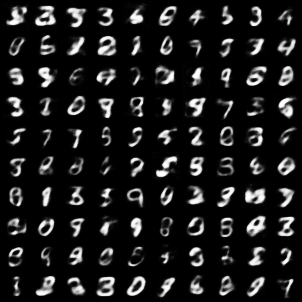

In [15]:
#방금 생성된 이미지 "prior_reconstruct_100.png"의 출력
from IPython.display import display
from PIL import Image

img = Image.open("prior_reconstruct_100.png")
display(img)